# Dogs vs Cats - Image classification notebook made by Øystein Knudsen

## Framing the problem and looking at the bigger picture

### The task at hand 

The goal of this notebook is to create a model which is able to
classify an image to be either a dog or a cat.

(read more at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

### The plan 

Given a large dataset of 25 000 photos (50/50 cats and dogs) I will
build and train a convolutional neural network to be able to classify the
new images correctly. I will be following the 8 step "Machine Learning Project Checklist" 
taken from the book "Hands on Machine Learning with Scikit Learn and TensorFlow" quite closely. 

 1. Frame the problem and look at the bigger picture.
 2. Get the data.
 3. Explore the data to gain insights.
 4. Prepeare the data to better expose the underlying data patterns to Machine Learning algorithms.
 5. Explore many different models and short-list the best ones.
 6. Fine-tune your models and combine them into a great solution.
 7. Present your solution.
 8. Launch, monitor and maintain your system. 
 

### The tools 

In [1]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import keras as ks
import cv2
import random
import numpy as np
from random import shuffle #shuffling the data


Using TensorFlow backend.


#### Keras
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

In my case I will be using Keras with a Tensorflow back-end. 

#### Tensorflow

Taken from tensorflow.org:

"TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains."

#### tqdm 
Simply just a tool for showing cool progress bars. It's nice to know the progress when working on big data sets.

#### NumPy

NumPy is the fundamental package for scientific computing with Python. It contains among other things:

- a powerful N-dimensional array object
- sophisticated (broadcasting) functions
- useful linear algebra, Fourier transform, and random number capabilities

Besides its obvious scientific uses, NumPy can also be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined. This allows NumPy to seamlessly and speedily integrate with a wide variety of databases.

#### Matplotlib.pyplot

pyplot is used for plotting data. e.g., create a figure, create plotting area in a figure, plot some lines in a plotting area, decorate the plot with labels, etc.
#### TODO: Fill inn as you go

## Getting the data

As mentioned the dataset is supplied in the Kaggle challenge. The dataset consists of 2 parts: 

Training set: 12500 pictures of dogs + 12500 pictures of cats. 
Test set: 12500 mixed pictures of dogs and cats.

The training set got the convenient naming convention of: "animal.number.jpg" For example: "cat.104.jpg" or "dog.0.jpg" which makes it an easy job to extract the label. 



    
    





In [2]:
TRAINING_DIRECTORY = 'dataset_train/'
TEST_DIRECTORY = 'dataset_test/'

In [3]:
train_images = [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY)] # The full data set 
train_dogs =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'dog' in i] # only dogs
train_cats =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'cat' in i] # only cats
test_images =  [TEST_DIRECTORY+i for i in os.listdir(TEST_DIRECTORY)] # Test images used for final validation of the model


# Creating a training set with a smaller number of pictures, in order to reduce the computing time later on. 
train = train_dogs[0:7000] + train_cats[0:7000]

## Exploring the data to gain insights

### Looking at some of the pictures 



In [5]:
def readRandomImage():
    randomImage = cv2.imread(train_images[random.randint(1,24999)])
    return randomImage

In [4]:
# Taken from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

def show_images(images, cols = 1, titles = None):
   
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [6]:
randomImages = []
for i in range (8): 
    randomImages.append(readRandomImage())

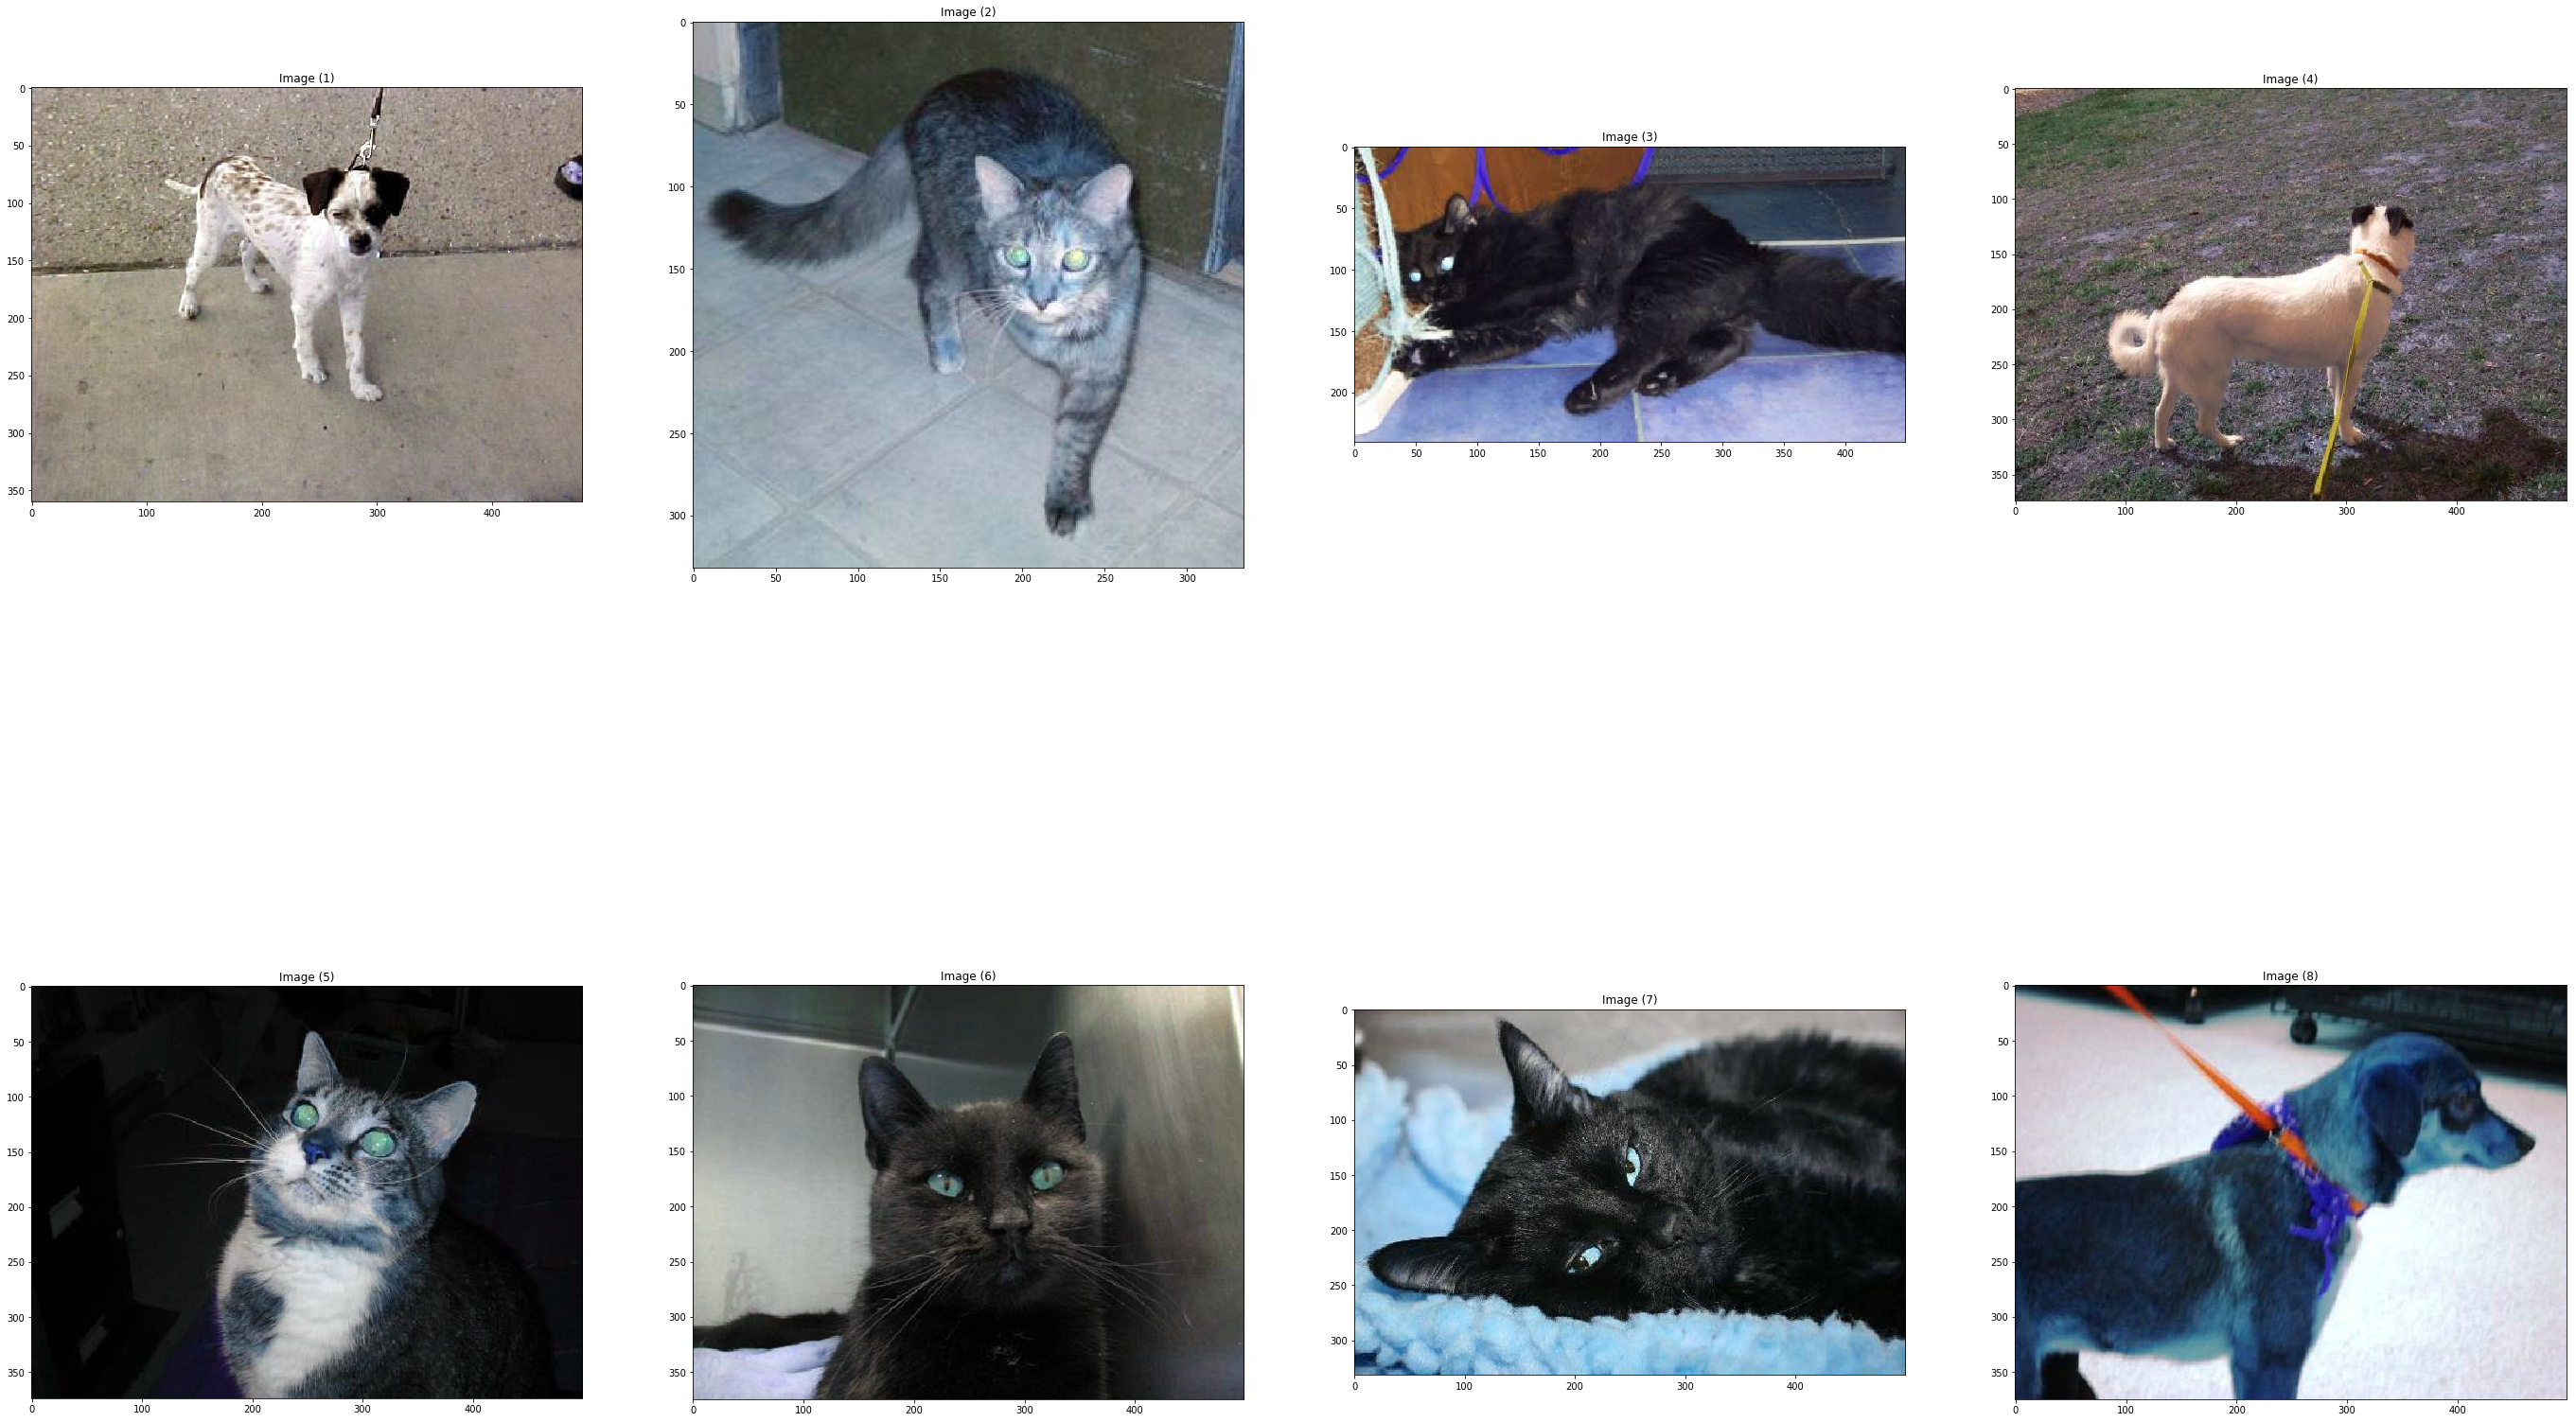

In [7]:
show_images(randomImages,2)

Looking at the 10 random images taken from the training set, we can see that there is a variety of pictures. 
There are some close ups, some with multiple animals, some unclear and some with the owner included. However these things are all fine to feed as input to the ML-algorithm, it's the varying picture size that might be an "issue". 

## Prepearing the data to better expose the underlying data patterns to ML-algorithms

#### Transforming the data set

Now that I have retrieved the data and looked at it, It's time to do the appropriate preperations. In order for me to feed this data into the ML-model, normalizing the data would be the best option. Meaning I will have to rezise all images into the same shape. 


Taking advantage of the naming convention we can easily extract the label from the path. Then convert it into a 
one-hot encoded value where [1,0] is a cat and [0,1] is a dog, as shown in the function below.

In [9]:
def extract_label(image):
    word_label = image.split('.')[-3] 
    final_label = word_label.split('/')[1] # Must be a better way to do this
    
    if final_label == 'cat' : return [1,0]
    
    elif final_label == 'dog' : return [0,1]

The function below does several important proseccing steps to our data. 

Iterates through our training data and does the following: 
    1. extracts label. 
    2. reads the image from path into an array. 
    3. converts the image into grayscale, in order to reduce image size. 
    4. appends the image and it's label to the new training data list.
    
    Then 
     shuffles the data. 
     saves the data such that we can load it from file when tweaking the model. 

In [8]:
IMG_SIZE = 90 # decleare constant that we can use to make all images same size



def create_training_data():
    training_data = [] 
    for img in tqdm(train):
        label = extract_label(img)
        img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE) # grayscale to reduce image size. 
        resized_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(resized_img_array), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
        

In [11]:
train_data = create_training_data()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14000/14000 [01:00<00:00, 232.29it/s]


#### Creating the test data 
I also need to create the test dataset which will be used to determine the models performance. 

In [12]:
def create_test_data(): 
    test_data = [] 
    for img in tqdm(test_images):
        without_filetype = img.split('.')[0]
        img_num = without_filetype.split('/')[1] #extract image number from path
        
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE) #read image and convert to greyscale
        img = cb2.resize(img, (IMG_SIZE, IMG_SIZE)) #resize image such that all images are the same size. 
        test_data.append([np.array(img), img_num]) 
    
    shuffle(test_data)
    np.save('test_data.npy', test_data) #Save to disk for future use 
    return test_data
         

####  A peek at the transformed data 

All images are now of size 90 x 90 and without colors. 

In [13]:
train_instance = train_data[0]
train_image = train_instance[0]
print(train_image.shape)

(90, 90)


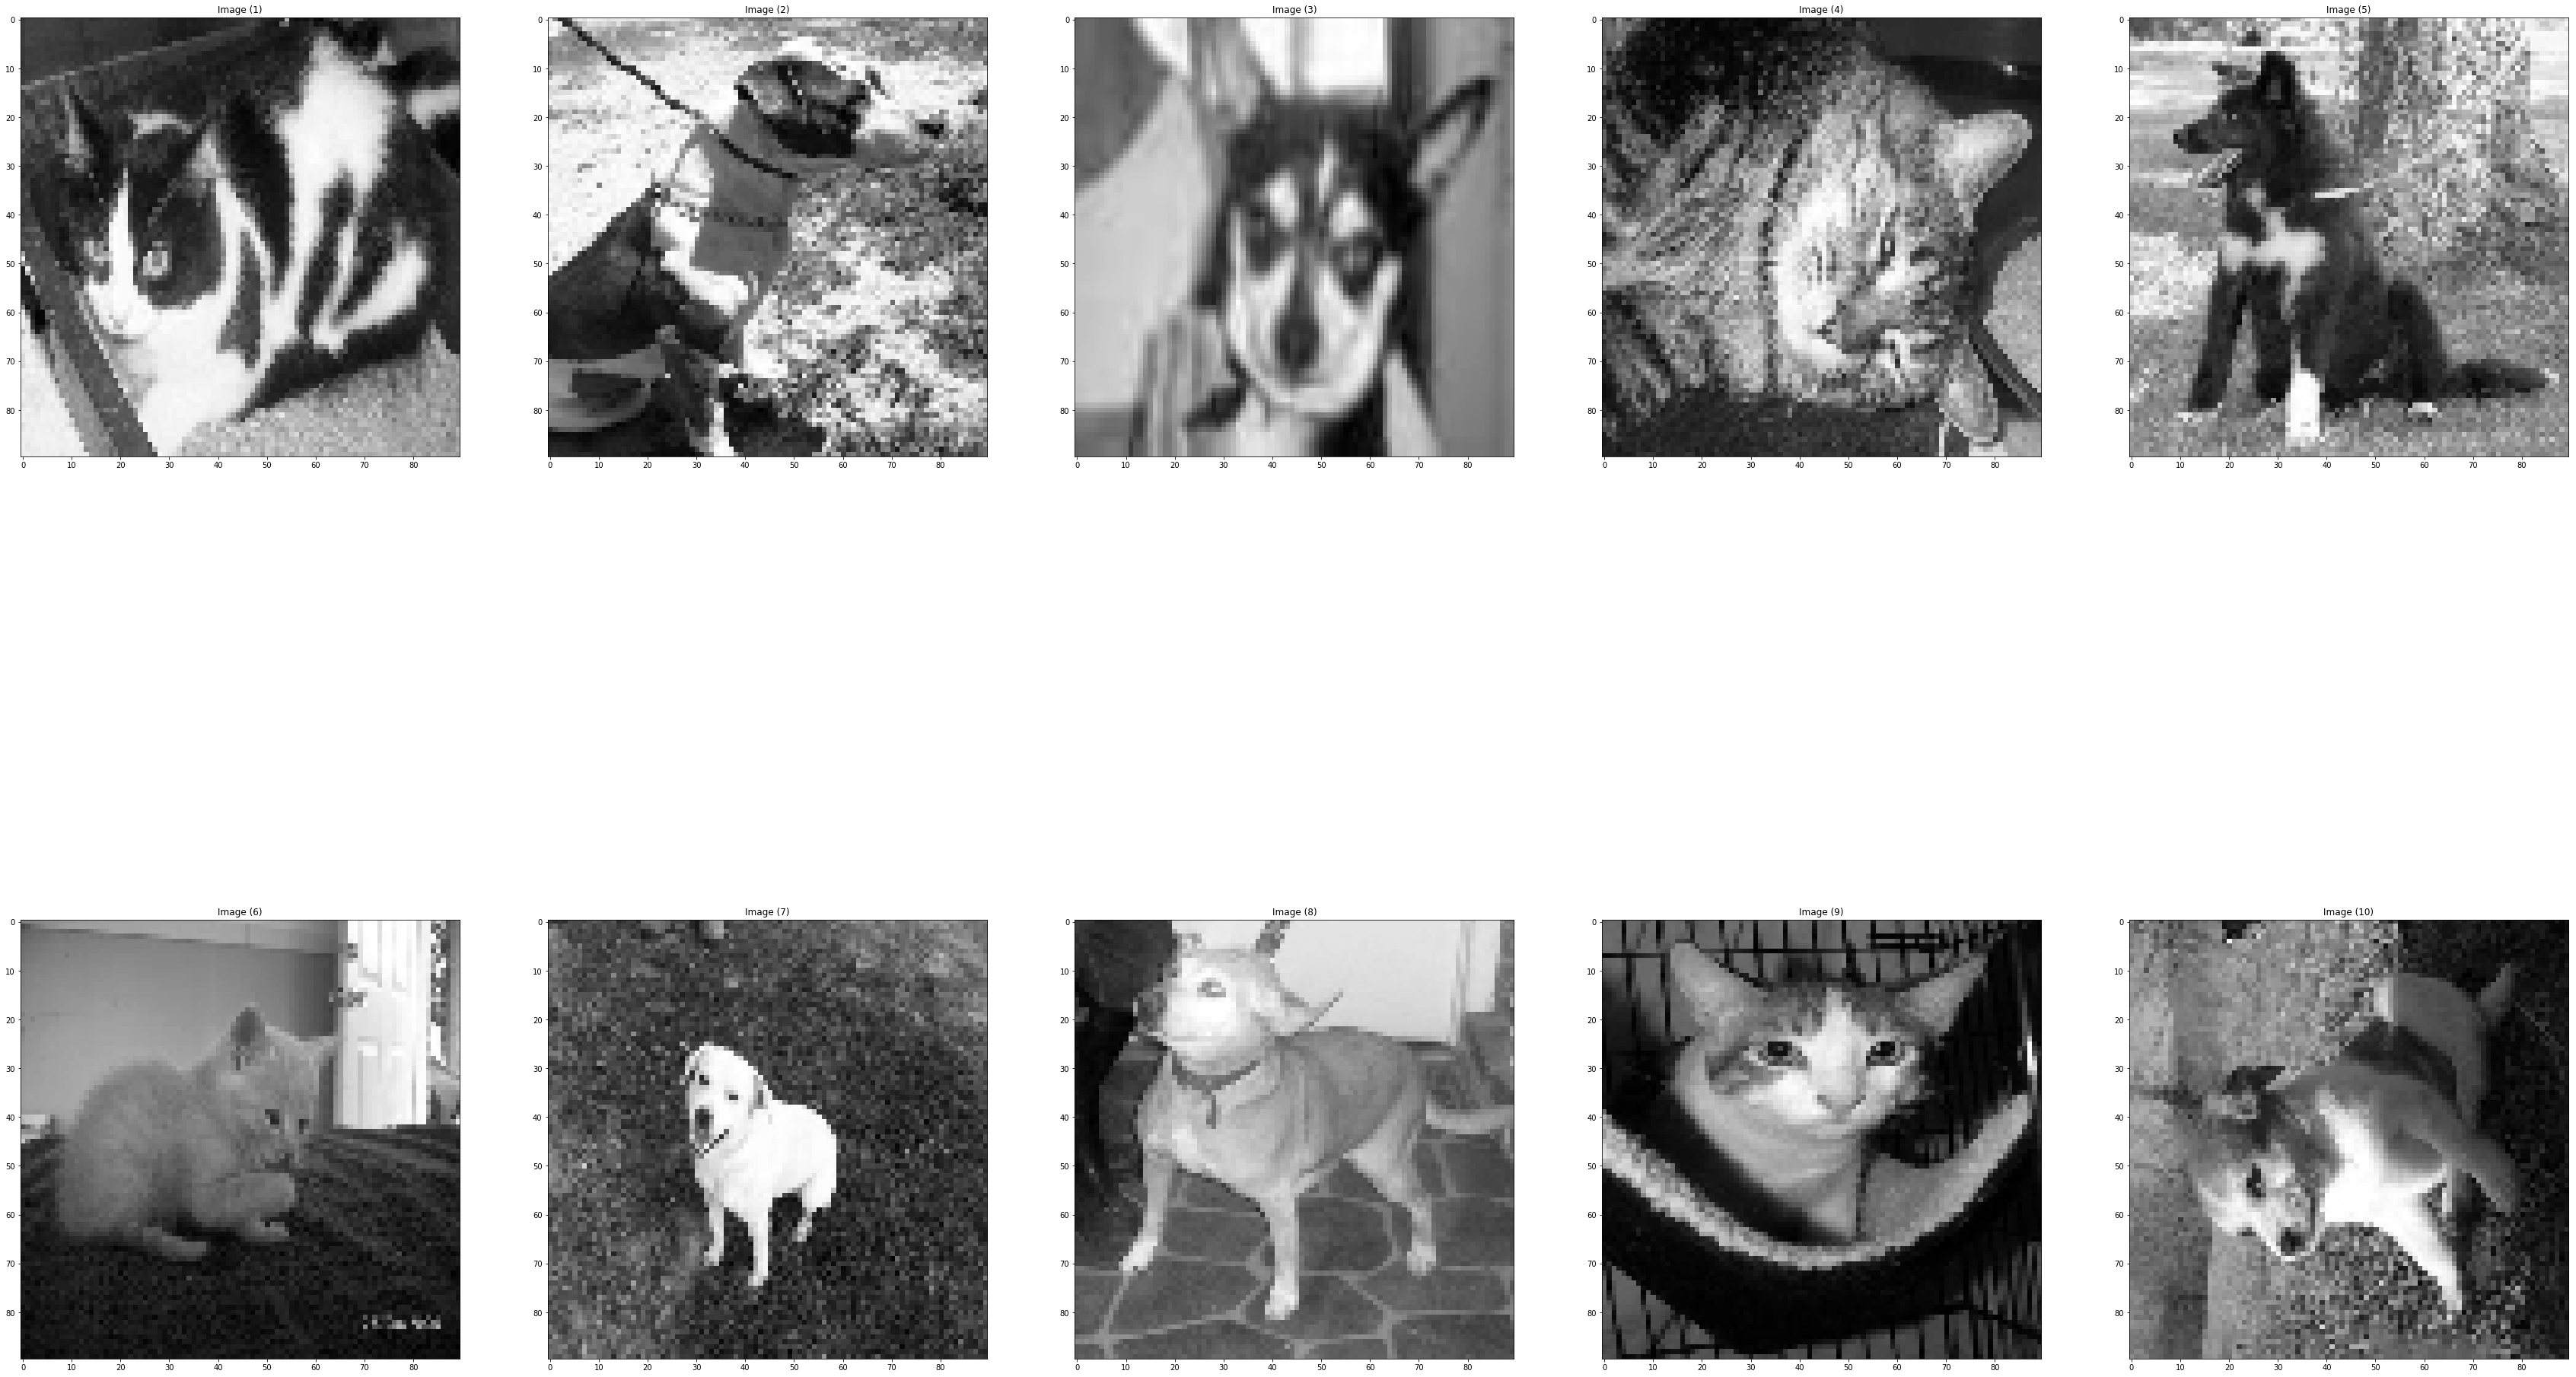

In [14]:
imagesToShow = []

for i in range (10): 
    obj = train_data[i]
    img = obj[0]
    imagesToShow.append(img)
show_images(imagesToShow,2)

#### seperating into features and labels 
When creating building my model I want to pass in my features as a NP-array and a label set (y). 
Therefore I need to split my current training dataset into two parts.

In [15]:
X = []
y = [] 

In [16]:
for features, label in train_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #Keras expects a nparray of this shape. 

In [21]:
X.shape

(14000, 90, 90, 1)

## Explore many different models and short-list the best ones. 

### The different types of models 
To solve this problem I have decided to use Keras, which is described earlier in the notebook. 
Keras has two built-in models available: sequential models and models created with the functional API. In addition to this you can also create custom models. 

#### The sequential model 

- The sequential model is a linear stack of layers. 
- Single input and single output.



#### The functional model 

- Enables you to define more complex models, such as multi-output models.
    




## Fine-tuneing the models and combining them into a great solution

In [18]:
from tensorflow.keras.models import Sequential #The model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [22]:
# Normalize data - max value for pixel = 255
X = X/255.0 
 


### Bulding the model 

In [24]:
X.shape

(14000, 90, 90, 1)

In [25]:
model = Sequential() #using sequential model


model.add(    Conv2D(64, (3,3), input_shape = X.shape[:1])) # conv layer: units, window size and input shape
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3))) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation( 'sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer = "adam",
              metrics = ['accuracy'])

model.fit(X, y, batch_size=32, validation_split=0.1)




ValueError: Input 0 of layer conv2d_2 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 14000]

## Presenting the solution

## Learning sources 

https://www.youtube.com/watch?v=YRhxdVk_sIs -- CNN's explained by deeplizard

https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL - Keras by deeplizard

https://medium.com/@parthvadhadiya424/hello-world-program-in-keras-with-cnn-dog-vs-cat-classification-efc6f0da3cc5 - Blogpost about using keras for image classification by parthvadhadiya424

https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter - Kaggle kernel for the dog-vs-cat competition by jeffd23

https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN - Deep Learning basics with Python, TensorFlow and Keras by sentdex

https://www.pugetsystems.com/labs/hpc/The-Best-Way-to-Install-TensorFlow-with-GPU-Support-on-Windows-10-Without-Installing-CUDA-1187/#vscode - Setup for environment 

https://www.kaggle.com/sentdex/full-classification-example-with-convnet - example notebook by sentdex

https://keras.io/getting-started/sequential-model-guide/ - The sequential model in Keras 

https://www.youtube.com/watch?v=VGCHcgmZu24 - The sequential model by Data Talks 

https://cran.rstudio.com/web/packages/keras/vignettes/about_keras_models.html - Keras models by The Comprehensive R Archive Network






